# Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import welch, find_peaks, cwt # Signal Processing


# Utils
import time
import os
loc = os.getcwd() 

# Matplotlib Params
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler

# Load in data

In [3]:
train_data = pd.read_hdf('/Users/wang_to/Documents/GitHub/Helicopter-Analysis/dataset/dftrain.h5')
valid_data = pd.read_hdf('/Users/wang_to/Documents/GitHub/Helicopter-Analysis/dataset/dfvalid.h5')
truth = pd.read_csv('/Users/wang_to/Documents/GitHub/Helicopter-Analysis/dataset/dfvalid_groundtruth.csv')

In [4]:
print(f'Train data shape: {train_data.shape}. Validation data shape: {valid_data.shape}. Truth: {truth.shape}')

Train data shape: (1677, 61440). Validation data shape: (594, 61440). Truth: (594, 2)


## Plotting and other visualisations

Text(0, 0.5, 'Magnitude')

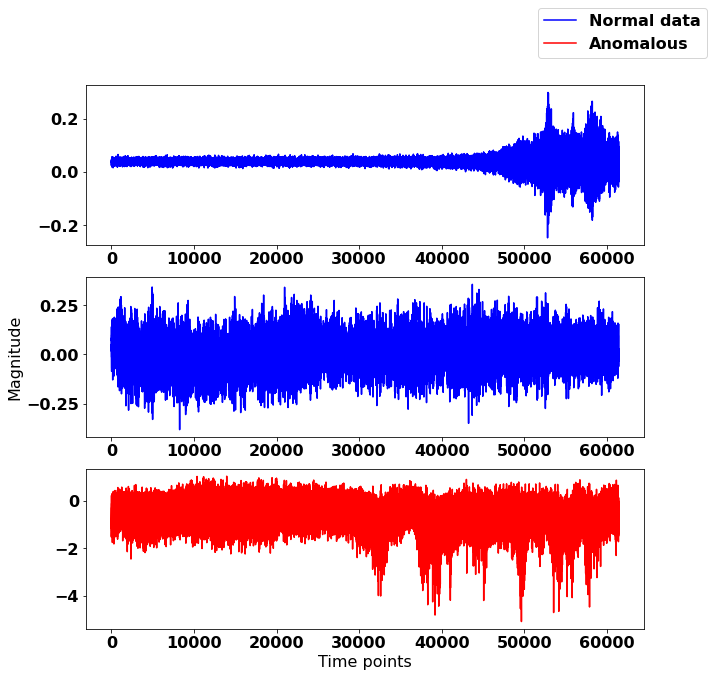

In [5]:
fig, axs = plt.subplots(3,1)
fig.set_size_inches(10,10)

axs[0].plot(train_data.iloc[0,:], color='blue')
axs[1].plot(valid_data.iloc[0,:], label='Normal data', color='blue')
axs[2].plot(valid_data.iloc[-1,:], label='Anomalous', color='red')
fig.legend()
axs[2].set_xlabel('Time points')
axs[1].set_ylabel('Magnitude')


# Data Transformations
In order for the model to accept our data, we need to massage our input dataframes into the correct form (the Conv1D layers are particularly fickle). In order for computations to be feasible, we downsampe by a factor of 5 (so we have ~12000 data points available).

In [7]:
valid_data

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0.070650,0.085524,0.076847,0.085524,0.120229,0.140061,0.107834,0.048340,0.014874,0.030987,...,0.018592,-0.017353,-0.049579,-0.061974,-0.022311,0.052058,0.091721,0.075608,0.045861,0.027268
1,-0.300685,-0.882656,-1.733789,-2.181179,-1.942328,-1.719240,-1.981126,-2.323034,-2.325459,-2.349708,...,0.454665,-0.782024,-1.725302,-1.829572,-1.170004,-0.278861,-0.152767,-1.035424,-2.312123,-3.199628
2,-0.056398,-0.152028,-0.058850,0.140994,0.170419,0.154480,0.270954,0.359228,0.334708,0.349420,...,0.023295,-0.019617,-0.062528,-0.094405,-0.105439,-0.123830,-0.166741,-0.159385,-0.106665,-0.131186
3,0.030618,0.020412,0.058747,0.124712,0.155828,0.161553,0.167777,0.170515,0.165038,0.141141,...,-0.073682,-0.052524,-0.023897,-0.009210,0.016429,0.058000,0.097828,0.114755,0.090360,0.054764
4,-1.071597,-6.912540,-13.677612,-16.463519,-15.790084,-11.653620,-7.668311,-9.942997,-14.321553,-13.704648,...,-5.227723,-6.107613,-6.577051,-6.123589,-5.324806,-4.965969,-4.464579,-3.442138,-3.794831,-6.133420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,-18.291415,-18.288957,-18.285270,-18.282812,-18.280354,-18.276668,-18.271752,-18.268065,-18.268065,-18.270523,...,-19.514201,-19.514201,-19.515430,-19.514201,-19.511744,-19.506828,-19.501912,-19.496996,-19.493310,-19.490852
590,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,...,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138
591,0.031800,-0.143735,-0.059784,0.248039,0.283655,-0.010176,-0.153911,0.069960,0.283655,0.183167,...,0.185711,0.151367,0.166631,0.171719,0.153911,0.160271,0.141191,0.050880,-0.020352,0.025440
592,-0.026635,-0.026635,-0.006721,0.009210,-0.008464,-0.036094,-0.039082,-0.026137,-0.017674,-0.017674,...,0.104549,0.103802,0.104798,0.094841,0.073184,0.058747,0.062978,0.081399,0.103056,0.113760


In [10]:
sample_rate = 5

train_test_data = train_data.iloc[:, ::sample_rate] #downsample to every 5th data point
anomaly_test_data = valid_data.iloc[:, ::sample_rate]

print(f'Train_test_data: {train_test_data.shape}, Anomaly_test_data: {anomaly_test_data.shape}.')

Train_test_data: (1677, 12288), Anomaly_test_data: (594, 12288).


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])

We now put together the inputs and get the data labels.

In [51]:
inputs = pd.concat([train_test_data, anomaly_test_data], axis=0)
inputs.reset_index(inplace=True, drop=True)
total_length = train_test_data.shape[0]
data_labels = pd.concat([pd.DataFrame(np.zeros(total_length)), truth.iloc[:,1]], axis=0)
data_labels.reset_index(inplace=True, drop=True)
data_labels = data_labels.to_numpy()


data_cat = to_categorical(data_labels)
print(f'{data_cat} {data_cat.shape} {sum(data_cat)}')

scaler=MinMaxScaler()
scaler.fit(inputs.T)
inputs_scaled = scaler.transform(inputs.T).T

train_X = inputs.values.reshape((-1, train_test_data.shape[1], 1))
train_X_scaled = inputs_scaled.reshape((-1, train_test_data.shape[1], 1))
data_category = to_categorical(data_labels) 

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] (2271, 2) [1974.  297.]


# Define Model in Tensorflow

Here, we define some initial parameters: batch size, regularisation parameters, learning rate, number of folds (for k-fold cross-validation) the starting input shape, optimiser (ADAM) and number of epochs. Note that the Conv1D layers actually take in input of the form _form_. We also give a list of metrics that we use to guide the training of the network.

In [69]:
# parameters
batch_size = 270
l1_reg = 1e-6
l2_reg = 1e-6
learning_rate = 1e-3
num_folds = 5

input_shape = (batch_size, train_test_data.shape[1])

num_epochs = 20

optim = Adam(lr=learning_rate)


METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

class book_conv1d_nn(tf.keras.Model):
    def __init__(self, n_outputs, type=False): # just get it working first. Set n_outputs = 1 for 1-class categorisation
        super(book_conv1d_nn, self).__init__()
        if type == 'heli':
            self.type = 'sigmoid'
        elif type == 'book':
            self.type = 'softmax'
        else: 
            print("Please provide a type argument.")
            return
        
        self.conv_in = Conv1D(
            filters=8,
            kernel_size=16, 
            input_shape=input_shape,
            activation='relu', 
            bias_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
            activity_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
            kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg), 
            padding='same'    

        )
        self.conv1 = Conv1D(
            filters=16, 
            kernel_size=8, 
            activation='relu',
            bias_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
            activity_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
            kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg), 
            padding='same', 
            name='hello'
        )
        self.conv2 = Conv1D(
            filters=32,
            kernel_size=4,
            activation='relu',
            bias_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
            activity_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
            kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg), 
            padding='same'   
        )

        self.conv3 = Conv1D(
            filters=32, 
            kernel_size=8, 
            activation='relu',
            bias_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
            activity_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
            kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg), 
            padding='same', 
            name='hello'
        )

        self.conv4 = Conv1D(
            filters=48, 
            kernel_size=8, 
            activation='relu',
            bias_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
            activity_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
            kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg), 
            padding='same', 
            name='hello'
        )

        self.maxPool = MaxPooling1D(pool_size=2, strides=2)
        self.flat = Flatten()
        self.D2 = Dense(n_outputs, activation = self.type)

    def call(self, inputs, training=False):
        x = self.conv_in(inputs)
        x = self.maxPool(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxPool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxPool(x)
        x = self.flat(x)
        x = self.D2(x)
        return(x)
        

# cross validation code

kfold = KFold(n_splits = num_folds, shuffle=True, random_state=1337)
kfold.get_n_splits(train_X)
fold_no = 1 

acc_per_fold = []
loss_per_fold = []

for train_index, test_index in kfold.split(train_X):
    print(f'Fold no: {fold_no}')
    X_train, X_test = train_X[train_index], train_X[test_index]
    Y_train, Y_test = data_labels[train_index], data_labels[test_index]

    model = book_conv1d_nn(n_outputs=1, type='heli')

    model.compile(optimizer=optim, loss='binary_crossentropy', 
    metrics=METRICS)
    print('-------------------------------------------')
    print(f'Fitting model on X_train, Y_train:')
    history = model.fit(X_train, Y_train, 
        batch_size=batch_size, 
        epochs=num_epochs)

    print(model.summary())

    scores = model.evaluate(train_X[test_index], data_labels[test_index], verbose=0)
    
    zipped = zip(model.metrics_names, scores)

    print(f"Score for fold {fold_no}: {[zips for zips in zipped]}.")

    fold_no += 1


Fold no: 1
-------------------------------------------
Fitting model on X_train, Y_train:
Train on 1816 samples
Epoch 1/20
1816/1816 [==============================] - 96s 53ms/sample - loss: 0.6610 - tp: 149.0000 - fp: 224.0000 - tn: 1346.0000 - fn: 97.0000 - accuracy: 0.8232 - precision: 0.3995 - recall: 0.6057 - auc: 0.8396 - prc: 0.6781
Epoch 2/20
1816/1816 [==============================] - 106s 59ms/sample - loss: 0.3179 - tp: 207.0000 - fp: 6.0000 - tn: 1564.0000 - fn: 39.0000 - accuracy: 0.9752 - precision: 0.9718 - recall: 0.8415 - auc: 0.9743 - prc: 0.9385
Epoch 3/20
1816/1816 [==============================] - 92s 51ms/sample - loss: 0.2342 - tp: 207.0000 - fp: 8.0000 - tn: 1562.0000 - fn: 39.0000 - accuracy: 0.9741 - precision: 0.9628 - recall: 0.8415 - auc: 0.9848 - prc: 0.9508
Epoch 4/20
1080/1816 [================>.............] - ETA: 36s - loss: 0.1838 - tp: 119.0000 - fp: 3.0000 - tn: 938.0000 - fn: 20.0000 - accuracy: 0.9787 - precision: 0.9754 - recall: 0.8561 - auc

In [ ]:
np.rint(model.predict(X_train))

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [ ]:
Y_train

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])